<a href="https://colab.research.google.com/github/leoliuuu/MovieRecommendation/blob/main/MovieLens_Collaborative_Filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import gdown
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Embedding, Flatten, Dense, Multiply, Concatenate
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load the Data

In [ ]:
# Download the zip file from google drive and unzip it
gdown.download('https://drive.google.com/uc?authuser=0&id=1oP_H072BGA1KSuY-PbwlYkTaEFE1W3eP&export=download', 'ml-latest-small.zip', quiet=False)
!unzip -qq ml-latest-small.zip

Downloading...
From: https://drive.google.com/uc?authuser=0&id=1oP_H072BGA1KSuY-PbwlYkTaEFE1W3eP&export=download
To: /content/ml-latest-small.zip
100%|██████████| 978k/978k [00:00<00:00, 96.0MB/s]


In [ ]:
data_path = "ml-latest-small/"

df_ratings = pd.read_csv(
    os.path.join(data_path, 'ratings.csv'),
    usecols=['userId', 'movieId', 'rating'],
    dtype={'userId': 'int32', 'movieId': 'int32', 'rating': 'float32'})

df_ratings.head  

<bound method NDFrame.head of         userId  movieId  rating
0            1        1     4.0
1            1        3     4.0
2            1        6     4.0
3            1       47     5.0
4            1       50     5.0
...        ...      ...     ...
100831     610   166534     4.0
100832     610   168248     5.0
100833     610   168250     5.0
100834     610   168252     5.0
100835     610   170875     3.0

[100836 rows x 3 columns]>

In [ ]:
n_users = len(df_ratings.userId.unique())
n_items = len(df_ratings.movieId.unique())

print('Unique Users:{};   Unique Movies:{}'.format(n_users,n_items))

user_maxId = df_ratings.userId.max()
item_maxId = df_ratings.movieId.max()

print('Max of User ID: {};  Max of Movie ID: {}'.format(user_maxId,item_maxId))

Unique Users:610;   Unique Movies:9724
Max of User ID: 610;  Max of Movie ID: 193609


In [ ]:
# Dimensional Space Reduction for matrix factorization

def reduce_item_dim(df_ratings):
    """
    Reduce item vector dimension to the number of distinct items in our data sets
    
    input: pd.DataFrame, df_ratings should have columns ['userId', 'movieId', 'rating']
    output: pd.DataFrame, df_ratings with new 'MovieID' that is compressed
    """
    # pivot
    df_user_item = df_ratings.pivot(index='userId', columns='movieId', values='rating')
    # reset movieId
    df_user_item = df_user_item.T.reset_index(drop=True).T
    # undo pivot/melt - compress data frame
    df_ratings_new = df_user_item \
        .reset_index('userId') \
        .melt(
            id_vars='userId', 
            value_vars=df_user_item.columns,
            var_name='movieId',
            value_name='rating')
    # drop nan and final clean up
    return df_ratings_new.dropna().sort_values(['userId', 'movieId']).reset_index(drop=True)

In [ ]:
print('reduce item dimension before:')
df_ratings.head()

reduce item dimension before:


,userId,movieId,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0


In [ ]:
df_ratings = reduce_item_dim(df_ratings)

print('reduce item dimension after:')
df_ratings.head()

reduce item dimension after:


,userId,movieId,rating
0,1,0,4.0
1,1,2,4.0
2,1,5,4.0
3,1,43,5.0
4,1,46,5.0


In [ ]:
# train/test data split

df_train, df_test = train_test_split(df_ratings,test_size=0.25,shuffle=True, random_state = 88)
print('shape of training data set:', df_train.shape)
print('shape of test data set:', df_test.shape)

shape of training data set: (75627, 3)
shape of test data set: (25209, 3)


#Generalized Matrix Factorization and Test Model

In [ ]:
def get_GMF_model(n_users, n_items, latent_dim, vu_reg, vi_reg):   
    """
    Build Generalized Matrix Factorization Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    latent_dim: int, embedded dimension for user vector and item vector
    vu_reg: float, L2 regularization of user embedded layer
    vi_reg: float, L2 regularization of item embedded layer

    Return
    ------
    A Keras Model with GMF model architeture
    """
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MF_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(vu_reg),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=latent_dim,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(vi_reg),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MF_Embedding_User(user_input))
    item_latent = Flatten()(MF_Embedding_Item(item_input))

    # Element-wise product of user and item embeddings 
    predict_vector = Multiply()([user_latent, item_latent])
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model


def train_model(model, learner, batch_size, epochs, val_split, inputs, outputs):
    """
    define training routine, train models and save best model
    
    Parameters
    ----------
    model: a Keras model
    learner: str, one of ['sgd', 'adam', 'rmsprop', 'adagrad']
    batch_size: num samples per update
    epochs: num iterations
    val_split: split ratio for validation data
    inputs: inputs data
    outputs: outputs data
    """
    # add customized metric
    def rmse(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_true - y_pred)))
    
    # compile model
    model.compile(optimizer=learner.lower(), loss='mean_squared_error', metrics=['mean_squared_error', rmse])
    
    # add call backs
    early_stopper = EarlyStopping(monitor='val_rmse', patience=10, verbose=1)
    model_saver = ModelCheckpoint(filepath=os.path.join(data_path, '/tmp/model.hdf5'),
                                  monitor='val_rmse',
                                  save_best_only=True,
                                  save_weights_only=True)
    # train model
    history = model.fit(inputs, outputs,
                        batch_size=batch_size,
                        epochs=epochs,
                        validation_split=val_split,
                        callbacks=[early_stopper, model_saver])
    return history


def load_trained_model(model, weights_path):
    model.load_weights(weights_path)
    return model

In [ ]:
# Create GMF Model

GMF_model = get_GMF_model(n_users,n_items,10,0,0)
GMF_model.summary()

Model: "model_10"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 10)        6110        user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 10)        97250       item_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Train GMF Model

# model config
batch_size = 64
epochs = 30
val_split = 0.25

#train model
history = train_model(GMF_model,'adam',batch_size, epochs, val_split,
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 56720 samples, validate on 18907 samples
Epoch 1/30
56720/56720 [==============================] - 3s 59us/sample - loss: 10.0604 - mean_squared_error: 10.0604 - rmse: 3.1479 - val_loss: 5.2264 - val_mean_squared_error: 5.2264 - val_rmse: 2.2833
Epoch 2/30
56720/56720 [==============================] - 3s 55us/sample - loss: 2.4838 - mean_squared_error: 2.4838 - rmse: 1.5482 - val_loss: 1.6326 - val_mean_squared_error: 1.6326 - val_rmse: 1.2725
Epoch 3/30
56720/56720 [==============================] - 3s 58us/sample - loss: 1.1643 - mean_squared_error: 1.1643 - rmse: 1.0732 - val_loss: 1.1933 - val_mean_squared_error: 1.1933 - val_rmse: 1.0864
Epoch 4/30
56720/56720 [==============================] - 3s 54us/sample - loss: 0.8713 - mean_squared_error: 0.8713 - rmse: 0.9280 - val_loss: 1.0559 - val_mean_squared_error: 1.0559 - val_rmse: 1.0216
Epoch 5/30
56720/56720 [==============================] - 3s 53us/sample - loss: 0.7501 - mean_squared_error: 0.7501 - rmse: 0.8612 - va

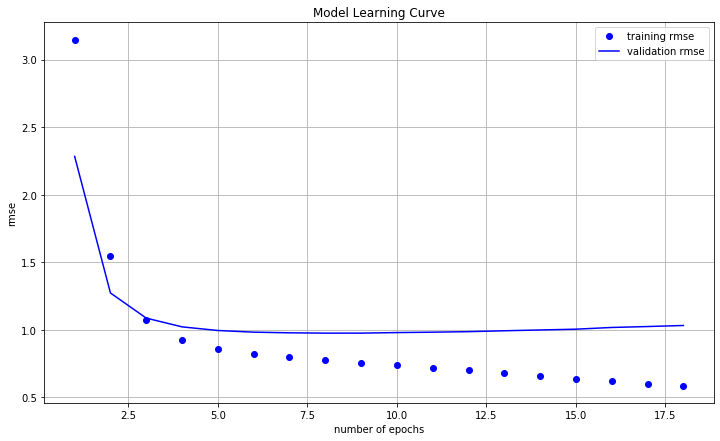

In [ ]:
# GMF Learning Curve

def plot_learning_curve(history, metric):
    """
    Plot learning curve to compare training error vs. validation error
    """
    # get training error
    errors = history.history[metric]
    # get validation error
    val_errors = history.history['val_{}'.format(metric)]
    # get epochs
    epochs = range(1, len(errors) + 1)

    # plot
    plt.figure(figsize=(12, 7))
    plt.plot(epochs, errors, 'bo', label='training {}'.format(metric))
    plt.plot(epochs, val_errors, 'b', label='validation {}'.format(metric))
    plt.xlabel('number of epochs')
    plt.ylabel(metric)
    plt.title('Model Learning Curve')
    plt.grid(True)
    plt.legend()
    plt.show()

plot_learning_curve(history,'rmse')

In [ ]:
# Model Testing

rmse = lambda true, pred: np.sqrt(np.mean(np.square(np.squeeze(predictions) - np.squeeze(df_test.rating.values))))

# load best model
GMF_model = get_GMF_model(n_users, n_items, 10, 0, 0)
GMF_model = load_trained_model(GMF_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = GMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.9871


# Multi-Layer Perceptron Model and Test Model

In [ ]:
# define MLP model architecture

def get_MLP_model(n_users, n_items, layers, reg_layers):
    """
    Build Multi-Layer Perceptron Model Topology
    
    Parameters
    ----------
    num_users: int, total number of users
    num_iterms: int, total number of items
    layers: list of int, each element is the number of hidden units for each layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    reg_layers: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(layers) == len(reg_layers)
    num_layer = len(layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    MLP_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='user_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=layers[0] // 2,
        embeddings_initializer='uniform',
        name='item_embedding',
        embeddings_regularizer=l2(reg_layers[0]),
        input_length=1) 
    
    # Crucial to flatten an embedding vector!
    user_latent = Flatten()(MLP_Embedding_User(user_input))
    item_latent = Flatten()(MLP_Embedding_Item(item_input))

    # The 0-th layer is the concatenation of embedding layers
    vector = Concatenate(axis=-1)([user_latent, item_latent])

    # MLP layers
    for idx in range(1, num_layer):
        layer = Dense(
            units=layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(reg_layers[idx]),
            name = 'layer%d' %idx)
        vector = layer(vector)
    
    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
# create MLP model

MLP_model = get_MLP_model(n_users, n_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model.summary()

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_embedding (Embedding)      (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
item_embedding (Embedding)      (None, 1, 32)        311200      item_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
# Train MLP Model

# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(MLP_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 56720 samples, validate on 18907 samples
Epoch 1/30
56720/56720 [==============================] - 4s 73us/sample - loss: 2.0749 - mean_squared_error: 2.0749 - rmse: 1.2138 - val_loss: 0.7942 - val_mean_squared_error: 0.7942 - val_rmse: 0.8876
Epoch 2/30
56720/56720 [==============================] - 4s 62us/sample - loss: 0.7219 - mean_squared_error: 0.7220 - rmse: 0.8451 - val_loss: 0.7788 - val_mean_squared_error: 0.7788 - val_rmse: 0.8777
Epoch 3/30
56720/56720 [==============================] - 3s 58us/sample - loss: 0.6721 - mean_squared_error: 0.6721 - rmse: 0.8146 - val_loss: 0.7686 - val_mean_squared_error: 0.7686 - val_rmse: 0.8707
Epoch 4/30
56720/56720 [==============================] - 3s 59us/sample - loss: 0.6370 - mean_squared_error: 0.6370 - rmse: 0.7931 - val_loss: 0.7698 - val_mean_squared_error: 0.7698 - val_rmse: 0.8717
Epoch 5/30
56720/56720 [==============================] - 4s 63us/sample - loss: 0.6033 - mean_squared_error: 0.6033 - rmse: 0.7715 - val_

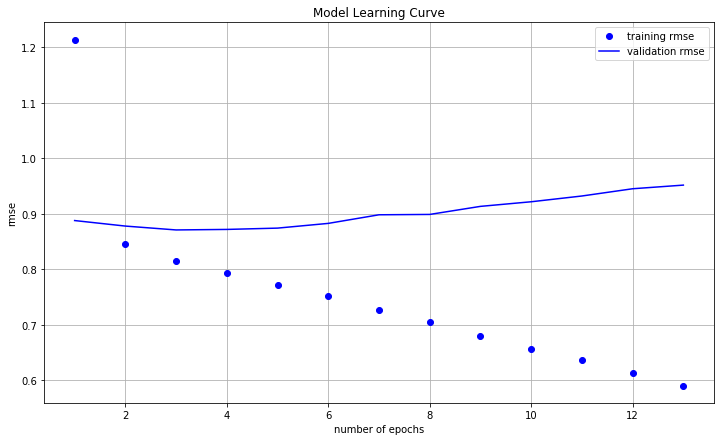

In [ ]:
# MLP Learning Curve

plot_learning_curve(history,'rmse')

In [ ]:
#MLP Model Testing

# load best model
MLP_model = get_MLP_model(n_users, n_items, [64, 32, 16, 8], [0, 0, 0, 0])
MLP_model = load_trained_model(MLP_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = MLP_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8807


# Train Neural Matrix Factorization (NeuMF) and Test Model

In [ ]:
# define NeuMF model architecture

def get_NeuMF_model(n_users, n_items, MF_dim, MF_reg, MLP_layers, MLP_regs):
    """
    Build Neural Matrix Factorization (NeuMF) Model Topology.
    This is stack version of both GMF and MLP
    
    Parameters
    ----------
    n_users: int, total number of users
    n_iterms: int, total number of items
    MF_dim: int, embedded dimension for user vector and item vector in MF
    MF_reg: tuple of float, L2 regularization of MF embedded layer
    MLP_layers: list of int, each element is the number of hidden units for each MLP layer,
        with the exception of first element. First element is the sum of dims of
        user latent vector and item latent vector
    MLP_regs: list of int, each element is the L2 regularization parameter for
        each layer in MLP

    Return
    ------
    A Keras Model with MLP model architeture
    """
    assert len(MLP_layers) == len(MLP_regs)
    num_MLP_layer = len(MLP_layers) # Number of layers in the MLP
    # Input variables
    user_input = Input(shape=(1,), dtype='int32', name='user_input')
    item_input = Input(shape=(1,), dtype='int32', name='item_input')

    # Embedding layer
    
    # MF
    MF_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_user_embedding',
        embeddings_regularizer=l2(MF_reg[0]),
        input_length=1)
    MF_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=MF_dim,
        embeddings_initializer='uniform',
        name='mf_item_embedding',
        embeddings_regularizer=l2(MF_reg[1]),
        input_length=1)
    
    # MLP
    MLP_Embedding_User = Embedding(
        input_dim=n_users + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_user_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1)
    MLP_Embedding_Item = Embedding(
        input_dim=n_items + 1,
        output_dim=MLP_layers[0] // 2,
        embeddings_initializer='uniform',
        name='mlp_item_embedding',
        embeddings_regularizer=l2(MLP_regs[0]),
        input_length=1) 
    
    # MF part
    mf_user_latent = Flatten()(MF_Embedding_User(user_input))
    mf_item_latent = Flatten()(MF_Embedding_Item(item_input))
    mf_vector = Multiply()([mf_user_latent, mf_item_latent])

    # MLP part
    mlp_user_latent = Flatten()(MLP_Embedding_User(user_input))
    mlp_item_latent = Flatten()(MLP_Embedding_Item(item_input))
    mlp_vector = Concatenate(axis=-1)([mlp_user_latent, mlp_item_latent])
    for idx in range(1, num_MLP_layer):
        layer = Dense(
            units=MLP_layers[idx],
            activation='relu',
            kernel_initializer='glorot_uniform',
            kernel_regularizer=l2(MLP_regs[idx]),
            name = 'layer%d' %idx)
        mlp_vector = layer(mlp_vector)
    
    # Concatenate MF and MLP parts
    predict_vector = Concatenate(axis=-1)([mf_vector, mlp_vector])

    # Final prediction layer
    prediction = Dense(1, kernel_initializer='glorot_uniform', name='prediction')(predict_vector)
    
    # Stitch input and output
    model = Model([user_input, item_input], prediction)
    
    return model

In [ ]:
# Create NeuMF Model
NeuMF_model = get_NeuMF_model(
    n_users=n_users,
    n_items=n_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model.summary()

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
user_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
item_input (InputLayer)         [(None, 1)]          0                                            
__________________________________________________________________________________________________
mlp_user_embedding (Embedding)  (None, 1, 32)        19552       user_input[0][0]                 
__________________________________________________________________________________________________
mlp_item_embedding (Embedding)  (None, 1, 32)        311200      item_input[0][0]                 
___________________________________________________________________________________________

In [ ]:
#Train NeuMF model
# model config
BATCH_SIZE = 64
EPOCHS = 30
VAL_SPLIT = 0.25

# train model
history = train_model(NeuMF_model, 'adam', BATCH_SIZE, EPOCHS, VAL_SPLIT, 
                      inputs=[df_train.userId.values, df_train.movieId.values],
                      outputs=df_train.rating.values)

Train on 56720 samples, validate on 18907 samples
Epoch 1/30
56720/56720 [==============================] - 5s 85us/sample - loss: 1.8390 - mean_squared_error: 1.8390 - rmse: 1.1634 - val_loss: 0.7865 - val_mean_squared_error: 0.7865 - val_rmse: 0.8820
Epoch 2/30
56720/56720 [==============================] - 4s 75us/sample - loss: 0.7179 - mean_squared_error: 0.7179 - rmse: 0.8421 - val_loss: 0.7745 - val_mean_squared_error: 0.7745 - val_rmse: 0.8754
Epoch 3/30
56720/56720 [==============================] - 4s 77us/sample - loss: 0.5950 - mean_squared_error: 0.5950 - rmse: 0.7667 - val_loss: 0.7849 - val_mean_squared_error: 0.7849 - val_rmse: 0.8816
Epoch 4/30
56720/56720 [==============================] - 4s 78us/sample - loss: 0.4516 - mean_squared_error: 0.4516 - rmse: 0.6670 - val_loss: 0.8231 - val_mean_squared_error: 0.8231 - val_rmse: 0.9024
Epoch 5/30
56720/56720 [==============================] - 4s 74us/sample - loss: 0.3668 - mean_squared_error: 0.3668 - rmse: 0.6007 - val_

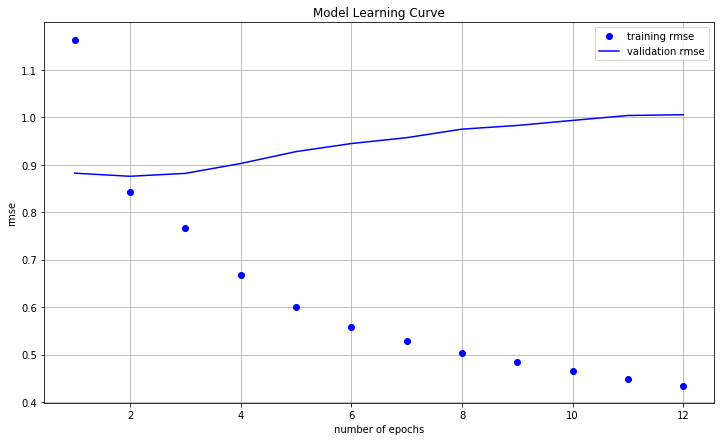

In [ ]:
# NeuMF Learning Curve
plot_learning_curve(history,'rmse')

In [ ]:
#NeuMF Model Testing
# load best model
NeuMF_model = get_NeuMF_model(
    n_users=n_users,
    n_items=n_items,
    MF_dim=10,
    MF_reg=(0, 0),
    MLP_layers=[64, 32, 16, 8],
    MLP_regs=[0, 0, 0, 0])
NeuMF_model = load_trained_model(NeuMF_model, os.path.join(data_path, '/tmp/model.hdf5'))
# make prediction using test data
predictions = NeuMF_model.predict([df_test.userId.values, df_test.movieId.values])
# get the RMSE
error = rmse(df_test.rating.values, predictions)
print('The out-of-sample RMSE of rating predictions is', round(error, 4))

The out-of-sample RMSE of rating predictions is 0.8858


# Comparison 


1.   ALS's best RMSE is
2.   GMF's best RMSE is 0.9871
3.   MLP's best RMSE is 0.8807
4.   NeuMF's best RMSE is 0.8858





In [ ]:
def fuzzy_matching(mapper, fav_movie, verbose=True):
    """
    return the closest match via fuzzy ratio. If no match found, return None
    
    Parameters
    ----------    
    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie
    
    verbose: bool, print log if True

    Return
    ------
    index of the closest match
    """
    match_tuple = []
    # get match
    for title, idx in mapper.items():
        ratio = fuzz.ratio(title.lower(), fav_movie.lower())
        if ratio >= 60:
            match_tuple.append((title, idx, ratio))
    # sort
    match_tuple = sorted(match_tuple, key=lambda x: x[2])[::-1]
    if not match_tuple:
        print('Oops! No match is found')
        return
    if verbose:
        print('Found possible matches in our database: {0}\n'.format([x[0] for x in match_tuple]))
    return match_tuple[0][1]



def make_recommendation(NeuMF_model, data, mapper, fav_movie, n_recommendations):
    """
    return top n similar movie recommendations based on user's input movie


    Parameters
    ----------
    model_knn: sklearn model, knn model

    data: movie-user matrix

    mapper: dict, map movie title name to index of the movie in data

    fav_movie: str, name of user input movie

    n_recommendations: int, top n recommendations

    Return
    ------
    list of top n similar movie recommendations
    """
    # fit
    NeuMF_model.fit(data)
    # get input movie index
    print('You have input movie:', fav_movie)
    idx = fuzzy_matching(mapper, fav_movie, verbose=True)
    # inference
    print('Recommendation system start to make inference')
    print('......\n')
    distances, indices = model_knn.kneighbors(data[idx], n_neighbors=n_recommendations+1)
    # get list of raw idx of recommendations
    raw_recommends = \
        sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
    # get reverse mapper
    reverse_mapper = {v: k for k, v in mapper.items()}
    # print recommendations
    print('Recommendations for {}:'.format(fav_movie))
    for i, (idx, dist) in enumerate(raw_recommends):
        print('{0}: {1}, with distance of {2}'.format(i+1, reverse_mapper[idx], dist))

In [ ]:
my_favorite = 'Social Network'

make_recommendation(
    model_knn=model_knn,
    data=movie_user_mat_sparse,
    fav_movie=my_favorite,
    mapper=movie_to_idx,
    n_recommendations=10)